<a href="https://colab.research.google.com/github/Emma-Cap/Deep-Learning-Project/blob/main/PROVAAAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import zipfile
import os

# Specifica il percorso del file zip
zip_path = '/content/archive.zip'

# Specifica la directory dove vuoi estrarre il file zip
extract_path = '/content/dataset'

# Estrai il file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Visualizza il contenuto delle directory estratte
for root, dirs, files in os.walk(extract_path):
    print(f"In directory: {root}")
    print(f"Cartelle: {dirs}")
    print(f"File: {files}")
    print("-" * 50)


In directory: /content/dataset
Cartelle: ['faces_02', 'faces']
File: []
--------------------------------------------------
In directory: /content/dataset/faces_02
Cartelle: ['part3']
File: []
--------------------------------------------------
In directory: /content/dataset/faces_02/part3
Cartelle: []
File: ['50_0_0_20170120222217575.jpg', '26_0_3_20170119181310597.jpg', '100_1_0_20170119212053665.jpg', '26_1_3_20170119192124129.jpg', '40_1_3_20170119204008588.jpg', '23_1_3_20170119164546693.jpg', '20_1_0_20170119153405080.jpg', '30_0_3_20170119195740600.jpg', '48_0_0_20170117153924476.jpg', '48_0_3_20170119201811053.jpg', '44_0_3_20170119195247387.jpg', '48_0_0_20170120134009260.jpg', '24_0_3_20170119165416686.jpg', '63_0_3_20170119211952608.jpg', '31_0_1_20170117130014250.jpg', '4_0_3_20170119150403983.jpg', '45_0_3_20170119203815607.jpg', '24_1_1_20170115235433094.jpg', '45_0_4_20170117130551448.jpg', '55_0_3_20170119204546494.jpg', '50_0_3_20170119183204846.jpg', '55_0_0_20170120140

In [6]:
import os
from glob import glob

# Percorsi delle cartelle che contengono le immagini
faces_dir = '/content/dataset/faces/Train'
faces_02_dir = '/content/dataset/faces_02/part3'

# Leggi tutte le immagini nelle due cartelle
faces_images = glob(os.path.join(faces_dir, '*.jpg'))
faces_02_images = glob(os.path.join(faces_02_dir, '*.jpg'))

# Conta le immagini nelle singole cartelle
num_faces_images = len(faces_images)
num_faces_02_images = len(faces_02_images)

# Combina tutte le immagini in una lista
all_images = faces_images + faces_02_images

# Conta il numero totale di immagini combinate
total_images = len(all_images)

# Percorso del file annotazioni
annotations_file = '/content/dataset/faces/train.csv'

# Conta il numero di annotazioni (linee nel file CSV, escludendo l'intestazione)
with open(annotations_file, 'r') as f:
    num_annotations = len(f.readlines()) - 1  # Rimuovi l'intestazione

# Stampa i risultati
print(f"Numero di immagini in 'faces/Train': {num_faces_images}")
print(f"Numero di immagini in 'faces_02/part3': {num_faces_02_images}")
print(f"Numero totale di immagini combinate: {total_images}")
print(f"Numero di annotazioni nel file CSV: {num_annotations}")


Numero di immagini in 'faces/Train': 19906
Numero di immagini in 'faces_02/part3': 3250
Numero totale di immagini combinate: 23156
Numero di annotazioni nel file CSV: 19906


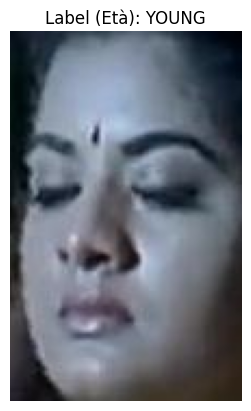

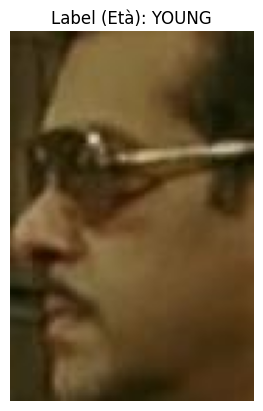

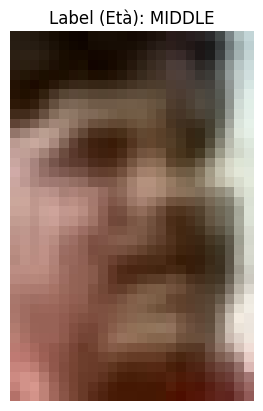

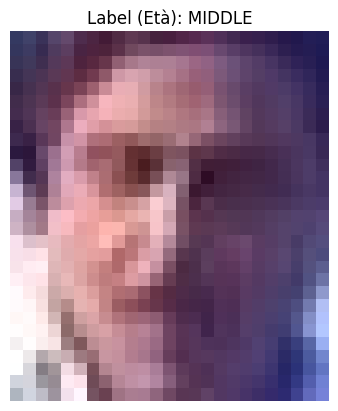

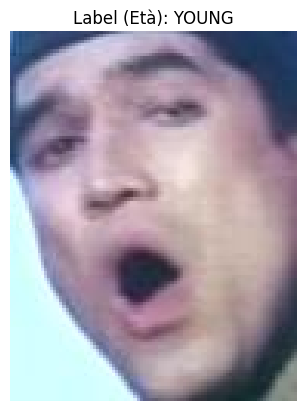

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Percorso del file CSV e della cartella immagini
annotations_file = '/content/dataset/faces/train.csv'
images_dir = '/content/dataset/faces/Train'

# Leggi il file CSV
annotations = pd.read_csv(annotations_file)

# Campiona casualmente 5 immagini
sample_images = annotations.sample(5)

# Plot delle immagini con le etichette
for idx, row in sample_images.iterrows():
    image_path = os.path.join(images_dir, row['ID'])  # Usa la colonna 'ID' per il nome del file
    label = row['Class']  # Usa la colonna 'Class' per la label

    # Carica e mostra l'immagine
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Label (Età): {label}")
    plt.axis('off')
    plt.show()


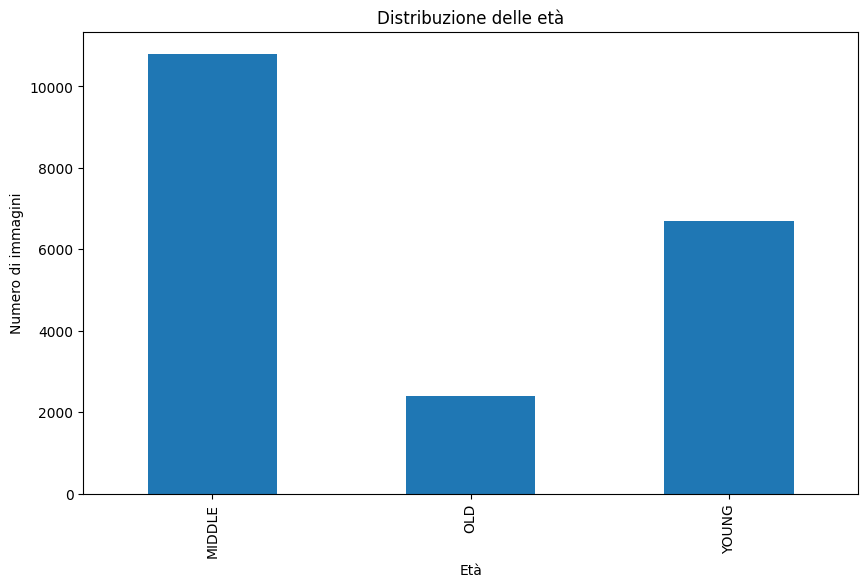

In [8]:
import matplotlib.pyplot as plt

# Distribuzione delle età
age_distribution = annotations['Class'].value_counts().sort_index()

# Plot distribuzione
plt.figure(figsize=(10, 6))
age_distribution.plot(kind='bar')
plt.title('Distribuzione delle età')
plt.xlabel('Età')
plt.ylabel('Numero di immagini')
plt.show()


In [9]:
from PIL import Image

# Controllo risoluzione immagini
low_res_images = []
for img_name in annotations['ID']:
    img_path = os.path.join(images_dir, img_name)
    with Image.open(img_path) as img:
        if img.size[0] < 100 or img.size[1] < 100:  # Soglia minima di risoluzione
            low_res_images.append(img_name)

print(f"Immagini a bassa risoluzione: {len(low_res_images)}")


Immagini a bassa risoluzione: 12706


In [10]:
from sklearn.model_selection import train_test_split

# Filtra il dataset per rimuovere le immagini di bassa qualità
high_quality_df = annotations[~annotations['ID'].isin(low_res_images)]

# Divisione stratificata in training e test
train_df, test_df = train_test_split(
    high_quality_df,
    test_size=0.2,
    stratify=high_quality_df['Class'],
    random_state=42
)

# Divisione stratificata del training set in training e validation
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['Class'],
    random_state=42
)

# Mostra la distribuzione dei set
print(f"Training set: {len(train_df)} immagini")
print(f"Validation set: {len(val_df)} immagini")
print(f"Test set: {len(test_df)} immagini")


Training set: 4608 immagini
Validation set: 1152 immagini
Test set: 1440 immagini


In [11]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Dataset personalizzato
class AgeDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['ID'])
        image = Image.open(img_path).convert('RGB')
        label = float(row['Class'])  # La classe è l'età
        if self.transform:
            image = self.transform(image)
        return image, label

# Trasformazioni per ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet richiede input 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione standard
])

# Creazione dei DataLoader
train_dataset = AgeDataset(train_df, '/content/dataset/faces/Train', transform)
val_dataset = AgeDataset(val_df, '/content/dataset/faces/Train', transform)
test_dataset = AgeDataset(test_df, '/content/dataset/faces/Train', transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# Carica ResNet-50 pre-addestrato
model = resnet50(pretrained=True)

# Congela i pesi dei livelli base
for param in model.parameters():
    param.requires_grad = False

# Sostituisci l'ultimo livello (per regressione)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # 1 output per la regressione (età)

# Invia il modello alla GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
import torch.optim as optim

# Funzione di perdita e ottimizzatore
criterion = nn.MSELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Solo l'ultimo livello è addestrabile


In [14]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), 'checkpoint.pt')  # Salva il modello migliore


In [15]:
print(annotations['Class'].unique())


['MIDDLE' 'YOUNG' 'OLD']


In [16]:
# Mappa delle classi a valori numerici
age_mapping = {
    'YOUNG': 20,
    'MIDDLE': 40,
    'OLD': 60
}

# Applica la mappatura al dataset
annotations['Class'] = annotations['Class'].map(age_mapping)


In [17]:
print(annotations.head())
print(annotations['Class'].unique())


          ID  Class
0    377.jpg     40
1  17814.jpg     20
2  21283.jpg     40
3  16496.jpg     20
4   4487.jpg     40
[40 20 60]


In [18]:
# Verifica se ci sono ancora valori non numerici nella colonna 'Class'
print(annotations['Class'].unique())


[40 20 60]


In [19]:
annotations['Class'] = annotations['Class'].astype(float)


In [20]:
print(annotations['Class'].dtypes)
print(annotations['Class'].unique())


float64
[40. 20. 60.]


In [21]:
# Aggiorna i DataFrame dopo la conversione
train_df['Class'] = train_df['Class'].map(age_mapping)
val_df['Class'] = val_df['Class'].map(age_mapping)
test_df['Class'] = test_df['Class'].map(age_mapping)

# Verifica i valori unici
print(train_df['Class'].unique())
print(val_df['Class'].unique())
print(test_df['Class'].unique())


[40 20 60]
[40 20 60]
[60 40 20]


In [22]:
# Forza la conversione in float
train_df['Class'] = train_df['Class'].astype(float)
val_df['Class'] = val_df['Class'].astype(float)
test_df['Class'] = test_df['Class'].astype(float)


In [23]:
class AgeDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['ID'])
        image = Image.open(img_path).convert('RGB')
        label = float(row['Class'])  # Converte esplicitamente
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)  # Forza il tipo a float32


In [24]:
# Ricrea i DataLoader con i DataFrame aggiornati
train_dataset = AgeDataset(train_df, '/content/dataset/faces/Train', transform)
val_dataset = AgeDataset(val_df, '/content/dataset/faces/Train', transform)
test_dataset = AgeDataset(test_df, '/content/dataset/faces/Train', transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [25]:
# Testa il DataLoader per verificare i dati
for images, labels in train_loader:
    print(f"Batch di immagini: {images.shape}")
    print(f"Batch di etichette: {labels}")
    break


Batch di immagini: torch.Size([32, 3, 224, 224])
Batch di etichette: tensor([20., 60., 20., 40., 40., 40., 20., 40., 40., 40., 20., 20., 60., 20.,
        40., 40., 20., 40., 40., 40., 20., 40., 60., 20., 40., 40., 40., 40.,
        20., 20., 60., 20.])


In [26]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Configurazione dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzando dispositivo: {device}")

# Trasformazioni per preprocessare le immagini
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet richiede immagini 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizzazione standard
])

# Dataset personalizzato
class AgeDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['ID'])
        image = Image.open(img_path).convert('RGB')  # Carica immagine come RGB
        if self.transform:
            image = self.transform(image)  # Applica trasformazioni
        label = float(row['Class'])  # Converte la classe in float (età)
        return image, label

# Creazione dei DataLoader
train_dataset = AgeDataset(train_df, '/content/dataset/faces/Train', transform)
val_dataset = AgeDataset(val_df, '/content/dataset/faces/Train', transform)
test_dataset = AgeDataset(test_df, '/content/dataset/faces/Train', transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Modello ResNet-18
model = resnet18(pretrained=True)

# Congela tutti i parametri del modello
for param in model.parameters():
    param.requires_grad = False

# Modifica l'ultimo strato per la regressione
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Output a singolo valore (età)
model.fc.requires_grad = True  # Sblocca solo l'ultimo strato
model = model.to(device)

# Ottimizzatore: aggiorna solo i parametri con requires_grad=True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Funzione di perdita (MSE per regressione)
criterion = nn.MSELoss()

# Funzione di training con timer per forward pass e batch
def train_model_with_timer(model, train_loader, val_loader, criterion, optimizer, n_epochs=10, patience=5):
    early_stopping = EarlyStopping(patience=patience)
    train_losses, val_losses = [], []

    # Timer globale
    start_training = time.time()

    for epoch in range(n_epochs):
        start_epoch = time.time()

        # Training
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            start_batch = time.time()  # Timer per il batch

            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            optimizer.zero_grad()

            # Timer per il forward pass
            start_forward = time.time()
            outputs = model(images)
            forward_time = time.time() - start_forward
            print(f"Tempo forward pass: {forward_time:.2f} secondi")  # Log del tempo

            # Calcolo della perdita e backward pass
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

            batch_time = time.time() - start_batch
            print(f"Tempo batch: {batch_time:.2f} secondi")  # Log del tempo per batch

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item() * images.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        epoch_time = time.time() - start_epoch
        print(f"Epoch {epoch+1}/{n_epochs}, "
              f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
              f"Epoch Time: {epoch_time:.2f} seconds")

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Timer globale
    total_training_time = time.time() - start_training
    print(f"Tempo totale di addestramento: {total_training_time / 60:.2f} minuti")

    # Carica il miglior modello
    model.load_state_dict(torch.load('checkpoint.pt'))
    return model, train_losses, val_losses

# Avvio del training con timer
print("Inizio del training...")
model, train_losses, val_losses = train_model_with_timer(model, train_loader, val_loader, criterion, optimizer, n_epochs=10, patience=3)
print("Training completato!")


Utilizzando dispositivo: cpu


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Inizio del training...
Tempo forward pass: 3.45 secondi
Tempo batch: 3.45 secondi
Tempo forward pass: 2.86 secondi
Tempo batch: 2.86 secondi
Tempo forward pass: 2.90 secondi
Tempo batch: 2.90 secondi
Tempo forward pass: 4.44 secondi
Tempo batch: 4.45 secondi
Tempo forward pass: 3.61 secondi
Tempo batch: 3.62 secondi
Tempo forward pass: 2.95 secondi
Tempo batch: 2.95 secondi
Tempo forward pass: 2.87 secondi
Tempo batch: 2.87 secondi
Tempo forward pass: 2.93 secondi
Tempo batch: 2.93 secondi
Tempo forward pass: 4.60 secondi
Tempo batch: 4.61 secondi
Tempo forward pass: 3.60 secondi
Tempo batch: 3.60 secondi
Tempo forward pass: 2.87 secondi
Tempo batch: 2.87 secondi
Tempo forward pass: 2.88 secondi
Tempo batch: 2.88 secondi
Tempo forward pass: 3.05 secondi
Tempo batch: 3.05 secondi
Tempo forward pass: 4.61 secondi
Tempo batch: 4.61 secondi
Tempo forward pass: 3.39 secondi
Tempo batch: 3.40 secondi
Tempo forward pass: 2.89 secondi
Tempo batch: 2.89 secondi
Tempo forward pass: 2.88 secondi


<ipython-input-26-5b1b5a29585c>:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pt'))


In [27]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Imposta il modello in modalità di valutazione
    test_loss = 0.0
    predictions, ground_truth = [], []

    with torch.no_grad():  # Disabilita il calcolo dei gradienti
        for images, labels in test_loader:
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item() * images.size(0)
            predictions.extend(outputs.squeeze().cpu().numpy())  # Salva predizioni
            ground_truth.extend(labels.cpu().numpy())  # Salva etichette reali

    test_loss = test_loss / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

    return predictions, ground_truth


In [28]:
print("Valutazione sul set di test...")
predictions, ground_truth = evaluate_model(model, test_loader, criterion)


Valutazione sul set di test...


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Confronto tra predizioni e valori reali
plt.figure(figsize=(10, 6))
plt.scatter(ground_truth, predictions, alpha=0.6)
plt.plot([min(ground_truth), max(ground_truth)], [min(ground_truth), max(ground_truth)], 'r--')  # Linea ideale
plt.xlabel('Età Reale')
plt.ylabel('Età Predetta')
plt.title('Confronto tra Età Reale e Predetta')
plt.grid()
plt.show()


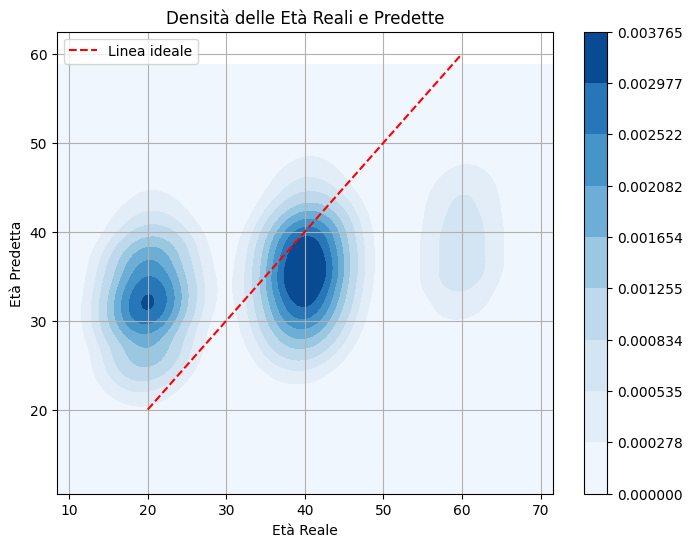

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Converti le età in array numpy
ground_truth = np.array(ground_truth)
predictions = np.array(predictions)

# Creazione della heatmap con Seaborn
plt.figure(figsize=(8, 6))
sns.kdeplot(x=ground_truth, y=predictions, cmap="Blues", fill=True, cbar=True, thresh=0)
plt.plot([min(ground_truth), max(ground_truth)], [min(ground_truth), max(ground_truth)], 'r--', label="Linea ideale")
plt.xlabel("Età Reale")
plt.ylabel("Età Predetta")
plt.title("Densità delle Età Reali e Predette")
plt.legend()
plt.grid()
plt.show()


Interpretazione
Densità:

Le aree più scure (intorno a 20-30 e 40-50) indicano una maggiore concentrazione di dati.
Questo significa che il modello sta predicendo la maggior parte delle età in questi intervalli.
Discrepanze:

Ci sono deviazioni dalla linea ideale, suggerendo che il modello non sta predicendo perfettamente.
Ad esempio, ci sono predizioni concentrate attorno a 30 per età reali di circa 20 anni: il modello tende a sovrastimare.
Per le età reali intorno a 40-50, le predizioni sembrano più accurate.
Generalizzazione:

Il modello sembra avere difficoltà a generalizzare al di fuori di questi cluster principali.
Può essere dovuto a uno sbilanciamento nei dati di training o a limiti nel modello.


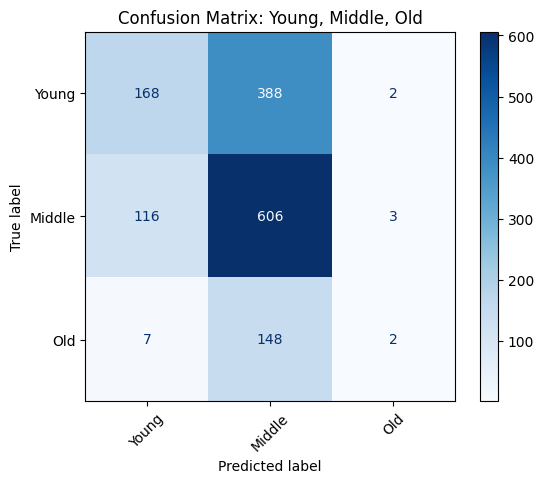

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Trasforma età reale e predetta in categorie: Young (0), Middle (1), Old (2)
def categorize_age(ages):
    categories = []
    for age in ages:
        if age < 30:
            categories.append(0)  # Young
        elif 30 <= age < 50:
            categories.append(1)  # Middle
        else:
            categories.append(2)  # Old
    return categories

# Categorizza età reale e predetta
real_categories = categorize_age(ground_truth)
pred_categories = categorize_age(predictions)

# Calcola la Confusion Matrix
labels = ["Young", "Middle", "Old"]
conf_matrix = confusion_matrix(real_categories, pred_categories, labels=range(len(labels)))

# Visualizza la Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Young, Middle, Old")
plt.show()


Analisi della Confusion Matrix: Young, Middle, Old
La Confusion Matrix mostra le prestazioni del modello nel classificare le età in tre categorie: Young, Middle, e Old. Ecco un'analisi dettagliata:

1. Categoria "Young"
Il modello ha classificato correttamente solo 168 persone come "Young", mentre una grande quantità (388) è stata erroneamente predetta come "Middle".
Questo indica che il modello fatica a distinguere le caratteristiche "giovani" da quelle "intermedie". Solo 2 persone sono state predette come "Old", il che è un errore raro per questa categoria.
2. Categoria "Middle"
Il modello si comporta meglio con questa categoria, con 606 predizioni corrette su un totale di dati appartenenti a questa classe.
Tuttavia, alcune persone "Middle" sono state erroneamente classificate come "Young" (116) o, in rari casi, come "Old" (3).
Questo suggerisce che il modello è più sicuro nel riconoscere caratteristiche intermedie rispetto a quelle delle altre classi.
3. Categoria "Old"
Qui il modello ha mostrato i risultati peggiori: solo 2 persone "Old" sono state classificate correttamente.
La maggior parte (148) è stata predetta come "Middle", il che evidenzia una chiara tendenza a sottostimare l'età.
Anche 7 persone "Old" sono state erroneamente classificate come "Young", il che è piuttosto sorprendente e potrebbe derivare da un dataset sbilanciato o da difficoltà del modello nel catturare caratteristiche facciali "anziane".
Problemi Evidenti
Bias verso la classe "Middle":
Il modello sembra avere una preferenza nel classificare le persone come "Middle", indipendentemente dalla loro vera età.
Difficoltà con le classi estreme (Young e Old):
Le classi "Young" e "Old" sono le più problematiche, con molti errori. Questo potrebbe derivare da:
Uno sbilanciamento nel dataset (ad esempio, meno immagini di persone "Young" o "Old").
Caratteristiche comuni tra le classi che confondono il modello.


In [30]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(ground_truth, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
from sklearn.metrics import r2_score
r2 = r2_score(ground_truth, predictions)
print(f"R² Score: {r2:.2f}")


Mean Absolute Error (MAE): 10.05
R² Score: 0.11


PROVIAMO UN ALTRO MODELLO ANCORA

In [26]:
# Controlla se train_df, val_df, e test_df sono già definiti
try:
    print("Train DataFrame:\n", train_df.head())
    print("Validation DataFrame:\n", val_df.head())
    print("Test DataFrame:\n", test_df.head())
except NameError as e:
    print("Errore: Uno o più DataFrame non sono definiti.")
    print(e)


Train DataFrame:
               ID  Class
14829  26527.jpg   40.0
185    24826.jpg   20.0
13455  12609.jpg   20.0
9151   22440.jpg   40.0
16271  10859.jpg   40.0
Validation DataFrame:
               ID  Class
18876  26024.jpg   40.0
16594  20509.jpg   40.0
9805    8640.jpg   40.0
17658   7895.jpg   40.0
934    16608.jpg   40.0
Test DataFrame:
               ID  Class
13190   8693.jpg   60.0
4494   22586.jpg   40.0
15758    413.jpg   20.0
15480  18482.jpg   20.0
14709   8072.jpg   40.0


In [ ]:
from transformers import AutoModelForImageClassification
import torch
import torch.nn as nn
import torch.optim as optim
import time

# Configurazione dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizzato: {device}")

# Carica il modello pre-addestrato
model_name = "google/vit-base-patch16-224"
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=1,  # Regressione con 1 output
    ignore_mismatched_sizes=True
)

# Modifica del classificatore finale
model.classifier = nn.Linear(model.config.hidden_size, 1)  # Regressione
model.to(device)

# Funzione di perdita
criterion = nn.MSELoss()

# Ottimizzatore
optimizer = optim.AdamW(model.parameters(), lr=5e-4)

# Funzione di training ottimizzata
def train_model_light(model, train_loader, val_loader, criterion, optimizer, n_epochs=2):
    best_val_loss = float('inf')
    print("\nInizio Training...\n")

    for epoch in range(n_epochs):
        start_time = time.time()

        # Training
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images).logits.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                outputs = model(images).logits.squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)

        # Risultati epoca
        elapsed_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{n_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {elapsed_time:.2f}s")

        # Salvataggio del modello migliore
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_light.pth")
            print("Nuovo miglior modello salvato!\n")

    print("Training completato.")
    return model

# Esegui il training
model = train_model_light(model, train_loader, val_loader, criterion, optimizer, n_epochs=2)


Dispositivo utilizzato: cpu


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Inizio Training...



In [ ]:
from transformers import AutoModelForImageClassification
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configurazione dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizzato: {device}")

# Carica il modello pre-addestrato
model_name = "google/vit-base-patch16-224"
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=1,  # Regressione con 1 output
    ignore_mismatched_sizes=True
)

# Modifica del classificatore finale
model.classifier = nn.Linear(model.config.hidden_size, 1)  # Regressione
model.to(device)

# Funzione di perdita
criterion = nn.MSELoss()

# Ottimizzatore
optimizer = optim.AdamW(model.parameters(), lr=5e-4)

# Funzione di training
def train_model_light(model, train_loader, val_loader, criterion, optimizer, n_epochs=2):
    best_val_loss = float('inf')
    print("\nInizio Training...\n")

    for epoch in range(n_epochs):
        start_time = time.time()

        # Training
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images).logits.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device, dtype=torch.float32)
                labels = labels.to(device, dtype=torch.float32)
                outputs = model(images).logits.squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)

        # Risultati epoca
        elapsed_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{n_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {elapsed_time:.2f}s")

        # Salvataggio del modello migliore
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_light.pth")
            print("Nuovo miglior modello salvato!\n")

    print("Training completato.")
    return model

# Funzione di valutazione
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            outputs = model(images).logits.squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            predictions.extend(outputs.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

    return predictions, ground_truths

# Funzione per visualizzare i risultati
def plot_results(ground_truths, predictions):
    plt.figure(figsize=(8, 6))
    plt.scatter(ground_truths, predictions, alpha=0.5)
    plt.plot([min(ground_truths), max(ground_truths)], [min(ground_truths), max(ground_truths)], 'r--')
    plt.xlabel("Valori Reali")
    plt.ylabel("Predizioni")
    plt.title("Confronto tra Predizioni e Valori Reali")
    plt.show()

# Funzione per calcolare le metriche
def calculate_metrics(ground_truths, predictions):
    mae = mean_absolute_error(ground_truths, predictions)
    mse = mean_squared_error(ground_truths, predictions)
    r2 = r2_score(ground_truths, predictions)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Training del modello
model = train_model_light(model, train_loader, val_loader, criterion, optimizer, n_epochs=2)

# Valutazione sul test set
predictions, ground_truths = evaluate_model(model, test_loader, criterion)

# Visualizzazione dei risultati
plot_results(ground_truths, predictions)

# Calcolo delle metriche
calculate_metrics(ground_truths, predictions)

# Salvataggio del modello finale
torch.save(model.state_dict(), "final_model.pth")
print("Modello salvato come 'final_model.pth'")
